In [285]:
#import packages

import sys
import numpy as np
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices('CPU'))


import os
import cv2
import zipfile
import datetime
import shutil
import itertools
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from enum import Enum
from random import sample
from tensorflow import keras
from patchify import patchify
# from keras_unet_collection import models
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img,img_to_array,ImageDataGenerator
from tensorflow.keras.layers import Dense,Flatten,Dropout,Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose

import os
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow.keras.models as keras_models



2.7.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [286]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [287]:
# Folder 
original_img_path = 'D:/Sribilone/unburn_2024/All_Dataset/A02-OverlapAMS/OverlapAMS/original/'
label_img_path = 'D:/Sribilone/unburn_2024/All_Dataset/A02-OverlapAMS/OverlapAMS/label/'

In [288]:
def dullrazor(img):
     # -*- coding: utf-8 -*-
     """
     Following are the DHR tasks followed in this example code:
     
     -- Applying Morphological Black-Hat transformation
     -- Creating the mask for InPainting task
     -- Applying inpainting algorithm on the image
     """

     src = cv2.imread(img)

     # Convert the original image to grayscale
     grayScale = cv2.cvtColor( src, cv2.COLOR_RGB2GRAY )

     # Kernel for the morphological filtering
     kernel = cv2.getStructuringElement(1,(17,17))

     # Perform the blackHat filtering on the grayscale image to find the 
     # hair countours
     blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)

     # intensify the hair countours in preparation for the inpainting 
     # algorithm
     ret,thresh2 = cv2.threshold(blackhat,10,255,cv2.THRESH_BINARY)

     # inpaint the original image depending on the mask
     dst = cv2.inpaint(src,thresh2,1,cv2.INPAINT_TELEA)
    
     return dst

In [289]:
# get a list of all image filenames in the directory
img_filenames = [f for f in os.listdir(label_img_path) if f.endswith('.tif')]

# define the number of images to display
num_images = 16

# randomly sample num_images images
files_path_ex = np.random.choice(img_filenames, num_images, replace=False)


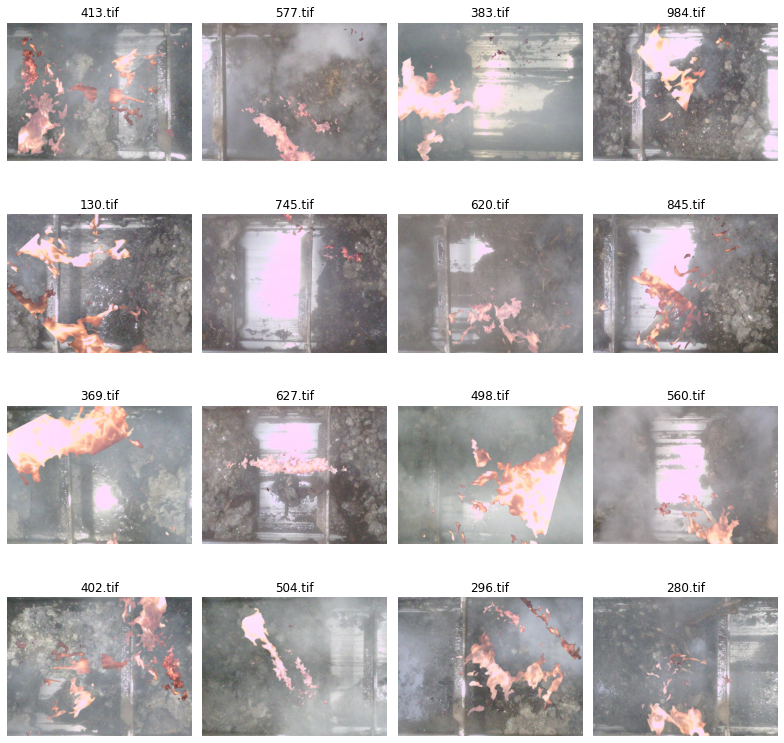

In [290]:
# Show the original image

# create a plot to display the images
fig, axs = plt.subplots(4, 4, figsize=(11, 11))
axs = axs.flatten()

# loop through each image filename and plot it
for i, file_path in enumerate(files_path_ex):
    img = Image.open(original_img_path + file_path)
    axs[i].imshow(img)
    axs[i].axis('off')
    axs[i].set_title(file_path)

plt.tight_layout()
plt.show()


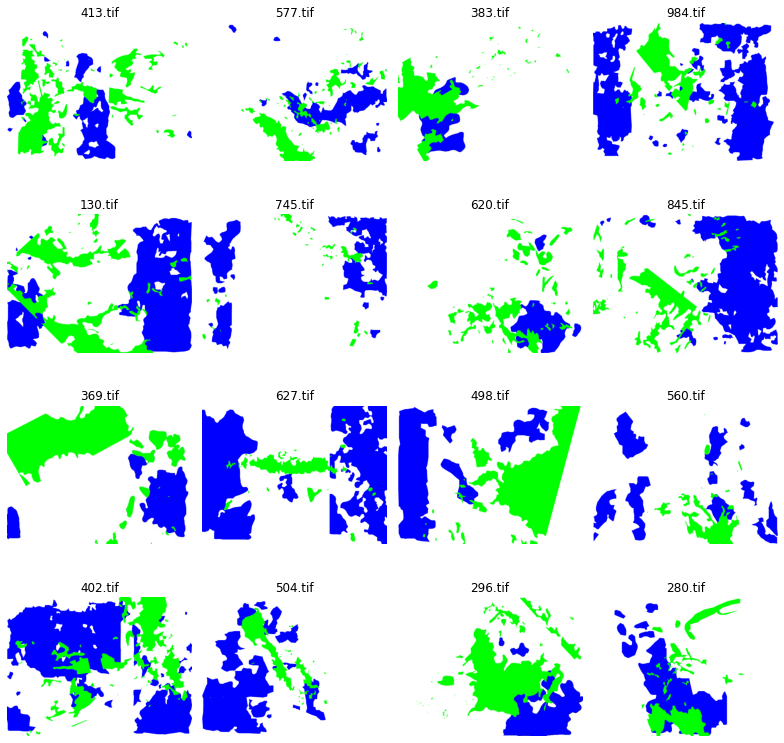

In [291]:
# Show the label image

# create a plot to display the images
fig, axs = plt.subplots(4, 4, figsize=(11, 11))
axs = axs.flatten()

# loop through each image filename and plot it
for i, file_path in enumerate(files_path_ex):
    img = Image.open(label_img_path + file_path)
    axs[i].imshow(img)
    axs[i].axis('off')
    axs[i].set_title(file_path)

plt.tight_layout()
plt.show()

In [292]:
# Convert image file to .tif format

# loop through each file in the directory
for filename in os.listdir(label_img_path):
    if filename.endswith('.png'):
        # open the image using PIL
        img = Image.open(os.path.join(label_img_path, filename))

        # convert the image to TIFF format
        tif_filename = os.path.splitext(filename)[0] + '.tif'
        img.save(os.path.join(label_img_path, tif_filename))

        # delete the original JPEG file
        os.remove(os.path.join(label_img_path, filename))


In [293]:
# Get a list of all the image filenames in the directory
images_path_label = [f for f in os.listdir(label_img_path) if f.endswith('.tif')]

# Loop through each image and read it using PIL
for image_filename in images_path_label:
    image_path = os.path.join(label_img_path, image_filename)
#     with Image.open(image_path) as im:
#         # Do something with the image, for example:
#         im.show()


In [294]:
# Get a list of all the image filenames in the directory
images_path_original = [f for f in os.listdir(original_img_path) if f.endswith('.tif')]

# Loop through each image and read it using PIL
for image_filename in images_path_original:
    image_path = os.path.join(original_img_path, image_filename)

In [295]:
path_original = original_img_path # 'C:/Users/korawitkj/Documents/Conda_env/unburn_dataset_ajkwan/Original/'
path_label = label_img_path #'C:/Users/korawitkj/Documents/Conda_env/unburn_dataset_ajkwan/Labelled/'

In [296]:
for root, dirs, files in os.walk(original_img_path):
    for file in files:
        if '-' in file:
            new_file_name = file.replace('-', '') # remove hyphens from the file name
            counter = 1
            while os.path.exists(os.path.join(root, new_file_name)):
                new_file_name = f"{os.path.splitext(file)[0]}_{counter}{os.path.splitext(file)[1]}"
                counter += 1
            os.rename(os.path.join(root, file), os.path.join(root, new_file_name))


In [297]:
path_label

'D:/Sribilone/unburn_2024/All_Dataset/A02-OverlapAMS/OverlapAMS/label/'

In [298]:
path_original

'D:/Sribilone/unburn_2024/All_Dataset/A02-OverlapAMS/OverlapAMS/original/'

In [299]:
pd.DataFrame(images_path_label)

,0
0,01.tif
1,02.tif
2,03.tif
3,04.tif
4,05.tif
...,...
995,995.tif
996,996.tif
997,997.tif
998,998.tif


In [300]:
from enum import Enum
class MaskColorMap(Enum):
    class_blue = (0, 0 ,255)
    class_green = (0, 255, 0)
    clas_whtie = (255, 255, 255)

n_classes = 3
U_net_class = ['class_blue', 'class_green', 'clas_whtie']

In [301]:
def load_images_and_patchify(img_path, patch_size):
    """
    :param patch_size: image patchify square size
    :param directory_path: path to root directory containing training and test images
    :return: list of images from directory
    """
    # initialize empty list for images
    instances = []
    # Reads image 
    image = img_to_array(load_img(img_path,target_size=(patch_size,patch_size)),dtype=np.uint8)

    # Extract patches from each image, step=patch_size means no overlap
    patch_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)
    
    # iterate over vertical patch axis
    for j in range(patch_img.shape[0]):
        # iterate over horizontal patch axis
        for k in range(patch_img.shape[1]):
            # patches are located like a grid. use (j, k) indices to extract single patched image
            single_patch_img = patch_img[j, k]
            # Drop extra extra dimension from patchify
            instances.append(np.squeeze(single_patch_img))

    return instances

In [302]:
def get_training_data(list_image, images_original,images_label, patch_size):
    # initialise lists
    image_dataset, mask_dataset = [], []

    # walk through root directory
    for i in tqdm(list_image):
        image_dataset.extend(load_images_and_patchify(images_original+i, patch_size=patch_size))
        mask_dataset.extend(load_images_and_patchify(images_label+i, patch_size=patch_size))

    # return input images and masks
    return np.array(image_dataset), np.array(mask_dataset)


In [303]:
X,Y = get_training_data(list_image = images_path_label, images_original = path_original, images_label= path_label, patch_size=224 )

100%|██████████| 1000/1000 [00:24<00:00, 40.51it/s]


In [304]:
# Test
# D:/Sribilone/unburn_2024/All_Dataset/A02-OverlapAMS/OverlapAMS/test/label
# D:/Sribilone/unburn_2024/All_Dataset/A02-OverlapAMS/OverlapAMS/test/original

In [305]:
ori_test = 'D:/Sribilone/unburn_2024/All_Dataset/A02-OverlapAMS/OverlapAMS/test/original/'
label_test = ' D:/Sribilone/unburn_2024/All_Dataset/A02-OverlapAMS/OverlapAMS/test/label/'

In [326]:
# Get a list of all the image filenames in the directory
images_path_label_test = [f for f in os.listdir(ori_test) if f.endswith('.jpg')]

# # Loop through each image and read it using PIL
# for image_filename in images_path_label_test:
#     image_path = os.path.join(ori_test, image_filename)
# #     with Image.open(image_path) as im:
# #         # Do something with the image, for example:
# #         im.show()


In [327]:
images_path_label_test

['541_visual_20240303_083053.jpg',
 '541_visual_20240303_083733.jpg',
 '541_visual_20240303_083803.jpg',
 '541_visual_20240303_110222.jpg',
 '541_visual_20240303_112043.jpg',
 '541_visual_20240303_125003.jpg',
 '541_visual_20240303_150613.jpg',
 '541_visual_20240303_151753.jpg',
 '541_visual_20240303_162642.jpg',
 '541_visual_20240303_210003.jpg',
 '541_visual_20240308_170653.jpg',
 '541_visual_20240308_170713.jpg',
 '541_visual_20240308_170843.jpg',
 '541_visual_20240308_171213.jpg',
 '541_visual_20240308_171403.jpg',
 '541_visual_20240308_172103.jpg',
 '541_visual_20240308_172123.jpg',
 '541_visual_20240308_172243.jpg',
 '541_visual_20240308_172923.jpg',
 '541_visual_20240308_175843.jpg']

In [328]:
X_testimg,Y_testimg  = get_training_data(list_image = images_path_label_test, images_original = ori_test, images_label= ori_test, patch_size=224 )

100%|██████████| 20/20 [00:00<00:00, 119.05it/s]


In [329]:
m, img_height, img_width, img_channels = X.shape

In [330]:
img_width, img_height

(224, 224)

In [331]:
def display_images(instances, rows=2, titles=None):
    """
    :param instances:  list of images
    :param rows: number of rows in subplot
    :param titles: subplot titles
    :return:
    """
    n = len(instances)
    cols = n // rows if (n / rows) % rows == 0 else (n // rows) + 1
    # Display Input Images and Target Labels
    plt.figure(figsize = (10,10),constrained_layout=True)
    img_start_name = 'result'
    number_count = 1
    
    for j, image in enumerate(instances):
        
        plt.subplot(4, 4, j + 1)
        plt.title('') if titles is None else plt.title(titles[j])
        plt.imshow(image)  


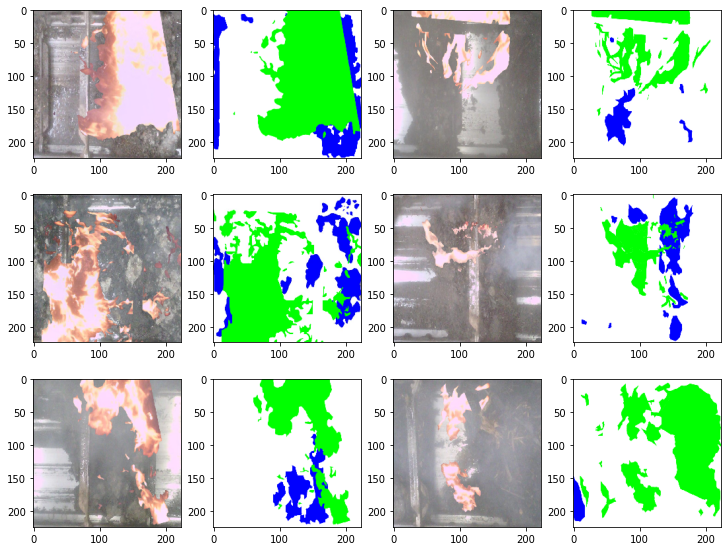

In [332]:
display_count = 6
random_index = [np.random.randint(0, m) for _ in range(display_count)]
sample_images = [x for z in zip(list(X[random_index]), list(Y[random_index])) for x in z]
display_images(sample_images, rows=3)

In [333]:
def one_hot_encode_masks(masks, num_classes):
    """
    :param masks: Y_train patched mask dataset
    :param num_classes: number of classes
    :return:
    """
    # initialise list for integer encoded masks
    integer_encoded_labels = []

    # iterate over each mask
    for mask in tqdm(masks):

        # get image shape
        _img_height, _img_width, _img_channels = mask.shape

        # create new mask of zeros
        encoded_image = np.zeros((_img_height, _img_width, 1)).astype(int)

        for j, cls in enumerate(MaskColorMap):
            encoded_image[np.all(mask == cls.value, axis=-1)] = j

        # append encoded image
        integer_encoded_labels.append(encoded_image)

    # return one-hot encoded labels
    return to_categorical(y=integer_encoded_labels, num_classes=num_classes)

In [334]:
# jaccard similarity: the size of the intersection divided by the size of the union of two sets
from keras import backend as K
def jaccard_index(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

In [335]:
# convert RGB values to ineger encoded labels for categorial_crossentropy
Y_unet = one_hot_encode_masks(Y, num_classes=3)

100%|██████████| 1000/1000 [00:03<00:00, 331.78it/s]


In [336]:
Y_unet_test = one_hot_encode_masks(Y_testimg, num_classes=3)
# X_testimg,Y_testimg 

100%|██████████| 20/20 [00:00<00:00, 425.55it/s]


In [337]:
print('Amount of X_testimg data:', X_testimg.shape[0])
# print('Amount of test data:', X_test.shape[0])

Amount of X_testimg data: 20


In [338]:
#Predict
def rgb_encode_mask(mask):
    # initialize rgb image with equal spatial resolution
    rgb_encode_image = np.zeros((mask.shape[0], mask.shape[1], 3))

    # iterate over MaskColorMap
    for j, cls in enumerate(MaskColorMap):
        # convert single integer channel to RGB channels
        rgb_encode_image[(mask == j)] = np.array(cls.value) / 255.
        
    return rgb_encode_image

In [319]:
# D:/Sribilone/unburn_2024/C06-UnetModelBasic/model_overlap_A02.h5

In [339]:
# Load the model from the .h5 file, passing the custom metric function to custom_objects
model_U = keras_models.load_model('D:/Sribilone/unburn_2024/C06-UnetModelBasic/model_overlap_A02.h5' , compile=False)#, custom_objects={'jaccard_index': jaccard_index})

In [340]:
# Load the model from the .h5 file, passing the custom metric function to custom_objects
model_K = keras_models.load_model('D:/Sribilone/unburn_2024/C06-UnetModelBasic/model_Unburn_V08_weight_model.h5', compile=False)

In [341]:
def rgb_encode_mask_x(mask):
    rgb_encode_image = np.zeros((mask.shape[0], mask.shape[1], 3))
    for j, cls in enumerate(MaskColorMap):
        rgb_encode_image[(mask == j)] = cls.value

    return rgb_encode_image

In [342]:
# Predict for model KJ
model_patch_size = 224

class MaskColorMapK(Enum):
    WHITE = [255, 255, 255]
    BLUE = [0, 0, 255]
    GREEN = [0, 255, 0]
    
def rgb_encode_mask_y(mask):
    rgb_encode_image = np.zeros((mask.shape[0], mask.shape[1], 3))
    for j, cls in enumerate(MaskColorMapK):
        rgb_encode_image[(mask == j)] =  cls.value

    return rgb_encode_image


def pre_process_image(image):
    print('pre_process_image:', image)
    processed_image = None
    try:
        instances = []
        image_array = keras.preprocessing.image.img_to_array(
            keras.preprocessing.image.load_img(image, target_size=(model_patch_size, model_patch_size)), dtype=np.uint8)
        patched_image = patchify(
            image_array, (model_patch_size, model_patch_size, 3), step=model_patch_size)
        for i in range(patched_image.shape[0]):
            for j in range(patched_image.shape[1]):
                single_patch_img = patched_image[i, j]
                instances.append(np.squeeze(single_patch_img))
        # dataset = []
        # dataset.extend(instances)
        # dataset_array = np.array(dataset)
        # expandsed_image = np.expand_dims(dataset_array[0], 0)
        # processed_image = expandsed_image
        instances_array = np.array(instances)
        processed_image = instances_array
    except Exception as ex:
        print('Exception: Image could not pre processed:', image)
        print(ex)

    return processed_image


def predict(image):
    # print('predict:', image)

    predicted_result = None
    try:
        processed_image = pre_process_image(image)
        if (processed_image is not None):
            keras.backend.clear_session()
            predicted = model_K.predict(processed_image)
            predicted_image_array = np.argmax(np.squeeze(predicted), axis=-1)
            predicted_image = rgb_encode_mask_y(predicted_image_array)
            predicted_result = predicted_image
        else:
            print('Image could not pre processed')
    except Exception as ex:
        print('Exception: Model could not predict')
        print(ex)

    return predicted_result

Total test image: 20


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

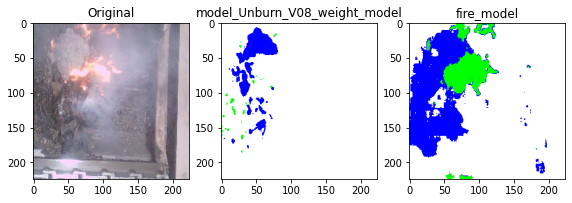

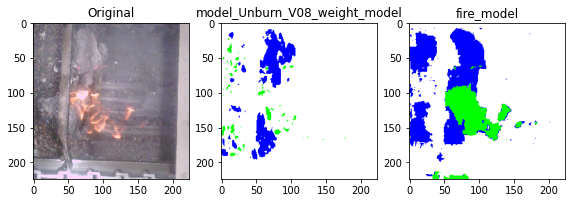

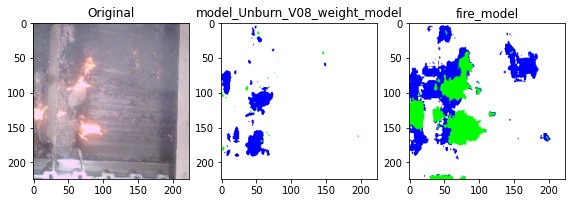

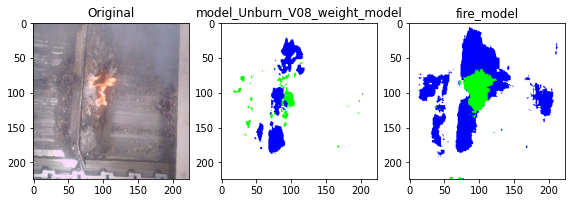

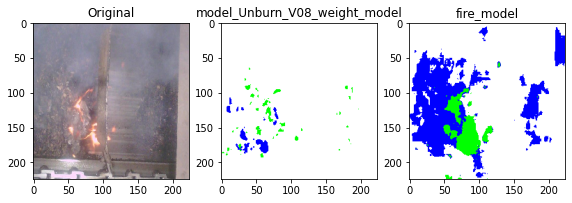

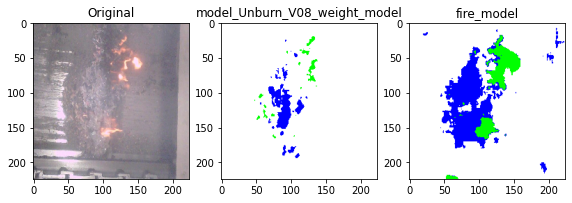

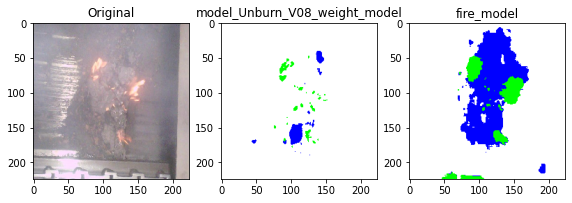

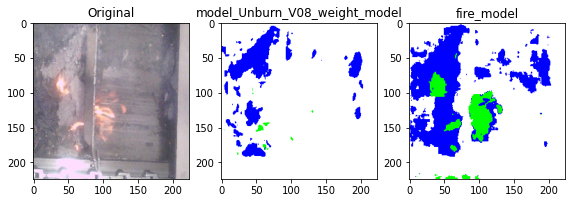

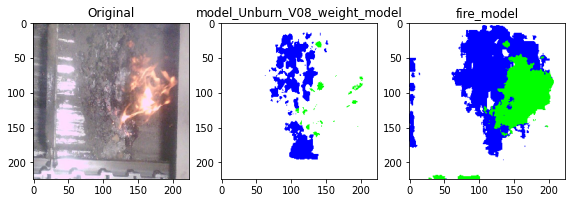

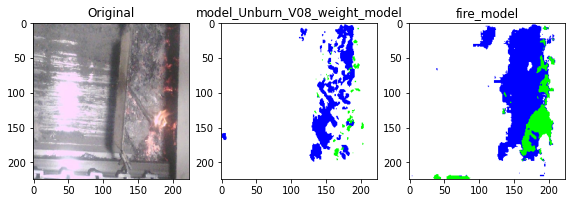

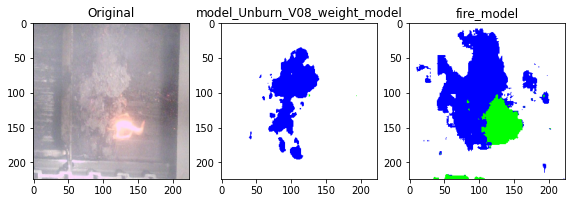

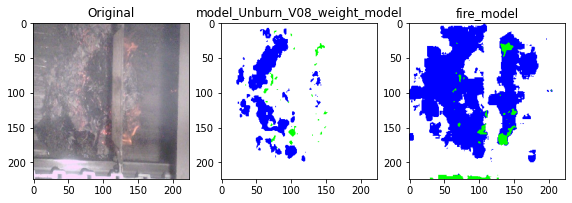

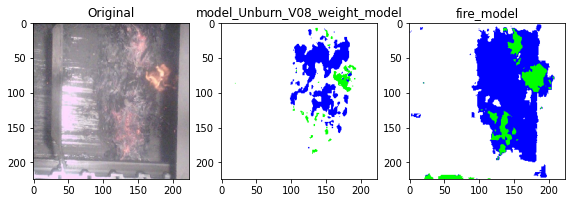

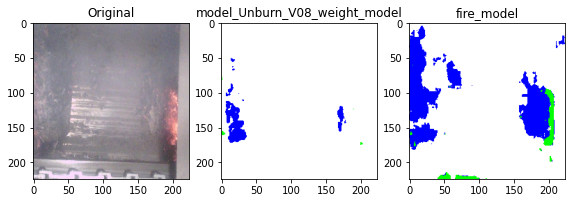

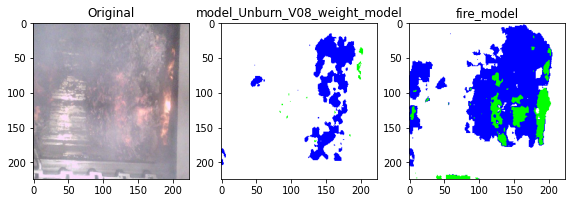

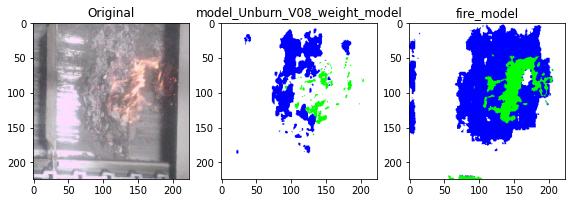

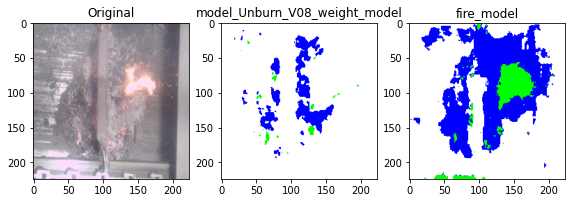

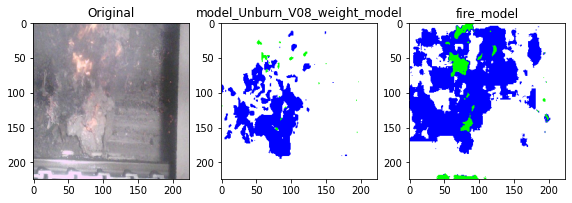

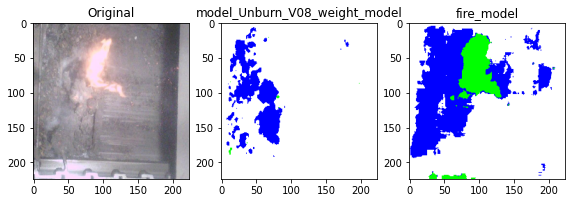

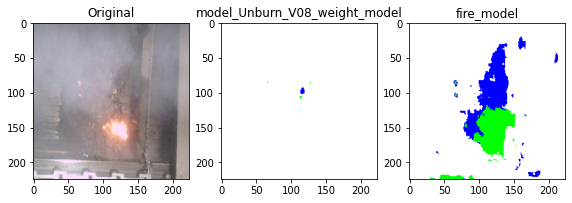

In [343]:
print(f'Total test image: {len(X_testimg)}')
for test_img_number in range(0, len(X_testimg)):
    
    # print(f'Number of test image: {test_img_number}')
    
    # extract test input image
    test_img = X_testimg[test_img_number]
    # print(test_img)
    
    # ground truth test label converted from one-hot to integer encoding
    ground_truth = Y_testimg[test_img_number]

    # expand first dimension as U-Net requires (m, h, w, nc) input shape
    test_img_input = np.expand_dims(test_img, 0)

    # make prediction with model and remove extra dimension
    prediction_u = np.squeeze(model_U.predict(test_img_input))

    # convert softmax probabilities to integer values
    predicted_img_u = np.argmax(prediction_u, axis=-1)

    # convert integer encoding to rgb values
    rgb_image_u = rgb_encode_mask(predicted_img_u)
    # rgb_ground_truth = rgb_encode_mask(ground_truth)

    # make prediction with model and remove extra dimension
    prediction_k = np.squeeze(model_K.predict(test_img_input))

    # convert softmax probabilities to integer values
    predicted_img_k = np.argmax(prediction_k, axis=-1)

    # convert integer encoding to rgb values
    rgb_image_k = rgb_encode_mask_y(predicted_img_k)


    # visualize model predictions
    display_images(
        [test_img, rgb_image_k, rgb_image_u,],
        rows=1, titles=['Original', 'model_Unburn_V08_weight_model', 'fire_model']
    )